In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'

calphad_results_dir = './v6_A-B-C-D-E_Sputtering/'
print("calphad results directory:", os.path.abspath(calphad_results_dir))

ML_results_dir = './v6_A-B-C-D-E_Sputtering_ML/v6_A-B-C-D-E_Sputtering_ML_All_Calc/'
print("")
print("ML results directory:", os.path.abspath(ML_results_dir))

calphad results directory: /nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/v6_A-B-C-D-E_Sputtering

ML results directory: /nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/v6_A-B-C-D-E_Sputtering_ML/v6_A-B-C-D-E_Sputtering_ML_All_Calc


### Creating lists of compositions and labels


In [26]:
# Define the set of elements for D and E
set_D_E = [{'Co'}, {'V'}, {'Mn'}, {'Mo'}, {'Cu'},
           {'Nb'}, {'W'}, {'Ti'}, {'Al'}, {'Si'}, {'Ta'}]

# Generate all possible combinations of D and E
compo_D_E_list = list(combinations(set_D_E, 2))

compo_A_B_C_D_E_list = []
compo_A_B_C_D_E_label_list = []

for compo_D_E in compo_D_E_list:
    # Convert the current combination to a list and flatten it
    compo_D_E_list = [item for sublist in compo_D_E for item in sublist]

    # Define the current combination of A, B, C, D, E
    compo_A_B_C_D_E = ['Fe', 'Cr', 'Ni'] + compo_D_E_list
    compo_A_B_C_D_E_merge = '_'.join([*compo_A_B_C_D_E])

    compo_A_B_C_D_E_label_merge = '-'.join([*compo_A_B_C_D_E])
    compo_A_B_C_D_E_list.append(compo_A_B_C_D_E_merge)
    compo_A_B_C_D_E_label_list.append(compo_A_B_C_D_E_label_merge)

print("compo_A_B_C_D_E_list : ", compo_A_B_C_D_E_list[0])
print("compo_A_B_C_D_E_label_list: ", compo_A_B_C_D_E_label_list[0])

full_path = os.path.abspath(calphad_results_dir + 'v6_' +
                            compo_A_B_C_D_E_list[0] + '_Sputtering' + '/count_fcc_fractions_byPalette.xlsx')
print("Full path:", full_path)

compo_A_B_C_D_E_list :  Fe_Cr_Ni_Co_V
compo_A_B_C_D_E_label_list:  Fe-Cr-Ni-Co-V
Full path: /nethome/home3/yuxiang.wu/CCA_CALPHAD_SSS_ML/v6_A-B-C-D-E_Sputtering/v6_Fe_Cr_Ni_Co_V_Sputtering/count_fcc_fractions_byPalette.xlsx


### Reads in relevant data, performs data manipulations, and saves the updated dataframes to files


In [27]:
# Define a list of compositions to iterate over
# compo_A_B_C_D_E_list = ['Fe_Cr_Ni_Mn_Ta', 'Fe_Cr_Ni_Mn_Ti', 'Fe_Cr_Ni_Mn_W']

# Initialize lists to hold dataframes
fcc_fractions_byPalette_list = []
SSS_fcc_byCompo_list = []
H1_C2_mean_std_fcc_byCompo_list = []


def process_composition(compo_A_B_C_D_E_fname, compo_A_B_C_D_E_label):

    # ----- read `count_fcc_fractions_byPalette` -----
    # Read in the FCC phase stability dataframe and add composition label
    fcc_fractions_byPalette = pd.read_excel(calphad_results_dir +
                                            'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/count_fcc_fractions_byPalette.xlsx')
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        compo_A_B_C_D_E=compo_A_B_C_D_E_label)

    # Add labels for FCC phase stability types
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        Gmin_FCC='min Gibbs energy')
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        eq_FCC='full equilibrium')

    # Append the updated dataframe to the list
    fcc_fractions_byPalette_list.append(fcc_fractions_byPalette)

    # ----- Read `SSS_byCompo` and `count_fcc_fractions_byCompo` -----
    # Read in the SSS and FCC fractions by composition dataframes
    SSS_byCompo = pd.read_excel(calphad_results_dir +
                                'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_byCompo.xlsx')
    fcc_fractions_byCompo = pd.read_excel(calphad_results_dir +
                                          'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/count_fcc_fractions_byCompo.xlsx')

    # Merge the two dataframes
    SSS_fcc_byCompo = pd.concat([SSS_byCompo, fcc_fractions_byCompo[[
                                'Gmin_FCC', 'eq_FCC', 'Gmin_eq_FCC']]], axis=1)

    # Create a new column 'sigma_SSS_FCC' for SSS values corresponding to FCC phase stability
    SSS_fcc_byCompo['sigma_SSS_FCC'] = SSS_fcc_byCompo.loc[SSS_fcc_byCompo['Gmin_eq_FCC'] == 1, 'sigma_SSS']
    SSS_fcc_byCompo = SSS_fcc_byCompo.assign(
        compo_A_B_C_D_E=compo_A_B_C_D_E_label)

    # Saving the new `SSS_FCC_byCompo.xlsx`
    if os.path.exists(calphad_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_FCC_byCompo.xlsx'):
        print('SSS_FCC_byCompo.xlsx: File already exists.')
    else:
        SSS_fcc_byCompo.to_excel(calphad_results_dir +
                                 'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_FCC_byCompo.xlsx', index=False)
        print('Saving '+'v6_' + compo_A_B_C_D_E_fname +
              '_Sputtering' + '/SSS_FCC_byCompo.xlsx')

    # Append the updated dataframe to the list
    SSS_fcc_byCompo_list.append(SSS_fcc_byCompo)

    # ----------------------------------------------------------------------------------------------------
    H1_C2_mean_std_fcc_byCompo = pd.read_excel(
        ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML.xlsx')

    # Create a new column 'sigma_SSS_FCC' for SSS values corresponding to FCC phase stability
    H1_C2_mean_std_fcc_byCompo['H1_new_pred_KFold_mean_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'H1_new_pred_KFold_mean']
    H1_C2_mean_std_fcc_byCompo['H1_new_pred_KFold_std_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'H1_new_pred_KFold_std']
    H1_C2_mean_std_fcc_byCompo['C2_new_pred_KFold_mean_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'C2_new_pred_KFold_mean']
    H1_C2_mean_std_fcc_byCompo['C2_new_pred_KFold_std_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'C2_new_pred_KFold_std']

    # Saving the excel: H1 C2 when FCC==1
    if os.path.exists(ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx'):
        print('SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.')
    else:
        H1_C2_mean_std_fcc_byCompo.to_excel(
            ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx')
        print('Saving ' + 'v6_' + compo_A_B_C_D_E_fname +
              '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx')

    # Append the updated dataframe to the list
    H1_C2_mean_std_fcc_byCompo_list.append(H1_C2_mean_std_fcc_byCompo)

    # Return your results
    return fcc_fractions_byPalette, SSS_fcc_byCompo, H1_C2_mean_std_fcc_byCompo


# Use ProcessPoolExecutor to run the loop in parallel
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_composition, compo_A_B_C_D_E_list,
                   compo_A_B_C_D_E_label_list), total=len(compo_A_B_C_D_E_list)))

# Unpack the results into your lists
for result in results:
    fcc_fractions_byPalette_list.append(result[0])
    SSS_fcc_byCompo_list.append(result[1])
    H1_C2_mean_std_fcc_byCompo_list.append(result[2])

# Display the first two rows of the loaded dataframes
display(fcc_fractions_byPalette_list[0].head(2))
display(SSS_fcc_byCompo_list[0].head(2))
display(H1_C2_mean_std_fcc_byCompo_list[0].head(2))

  0%|          | 0/55 [00:00<?, ?it/s]

SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.







SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.


SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCo

  2%|▏         | 1/55 [00:04<04:20,  4.83s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.



  4%|▎         | 2/55 [00:04<01:49,  2.07s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.



SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.



SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.x

  5%|▌         | 3/55 [00:05<01:06,  1.28s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


 11%|█         | 6/55 [00:05<00:23,  2.04it/s]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


100%|██████████| 55/55 [00:05<00:00,  9.78it/s]


,ABCDE,Gmin_FCC_fraction,eq_FCC_fraction,Gmin_eq_FCC_fraction,compo_A_B_C_D_E,Gmin_FCC,eq_FCC
0,V-Co-Ni-Cr-Fe,57.971014,44.927536,44.927536,Fe-Cr-Ni-Co-V,min Gibbs energy,full equilibrium
1,V-Co-Ni-Fe-Cr,55.072464,52.173913,49.275362,Fe-Cr-Ni-Co-V,min Gibbs energy,full equilibrium


,Fe,Cr,Ni,Co,V,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,Gmin_FCC,eq_FCC,Gmin_eq_FCC,sigma_SSS_FCC,compo_A_B_C_D_E
0,0.33,0.03,0.05,0.12,0.47,63.740744,0.329844,0.092273,456.766541,0,0.0,0,NaN,Fe-Cr-Ni-Co-V
1,0.39,0.05,0.05,0.11,0.40,66.837689,0.322980,0.091240,464.791066,0,0.0,0,NaN,Fe-Cr-Ni-Co-V


,Unnamed: 0,Fe,Cr,Ni,Co,V,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,...,sigma_SSS_FCC,compo_A_B_C_D_E,H1_new_pred_KFold_mean,H1_new_pred_KFold_std,C2_new_pred_KFold_mean,C2_new_pred_KFold_std,H1_new_pred_KFold_mean_FCC,H1_new_pred_KFold_std_FCC,C2_new_pred_KFold_mean_FCC,C2_new_pred_KFold_std_FCC
0,0,34.167395,2.891940,5.441344,13.111107,44.388214,63.740744,0.329844,0.092273,456.766541,...,NaN,Fe-Cr-Ni-Co-V,501.462250,121.009743,299.628906,225.678894,NaN,NaN,NaN,NaN
1,1,40.204113,4.798947,5.417690,11.966268,37.612981,66.837689,0.322980,0.091240,464.791066,...,NaN,Fe-Cr-Ni-Co-V,492.357391,119.546692,312.933289,225.030975,NaN,NaN,NaN,NaN


### Rank the sequence of ABCDE by `Gmin_eq_FCC_max`


In [28]:
# ----- rank by `Gmin_eq_FCC_mean`
# # Calculate the mean of the Gmin_eq_FCC_fraction for each set of data and rank them in descending order
# Gmin_eq_FCC_mean = [np.mean(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values)
#                     for fcc_fractions_byPalette in fcc_fractions_byPalette_list]
# print(Gmin_eq_FCC_mean)

# ranked_indices = np.argsort(Gmin_eq_FCC_mean)[::-1]  # Sort in descending order

# Gmin_eq_FCC_mean_sort = [Gmin_eq_FCC_mean[i] for i in ranked_indices]  # Sort the mean values in the ranked order
# print(Gmin_eq_FCC_mean_sort)


# ----- rank by `Gmin_eq_FCC_max`
# Calculate the max of the Gmin_eq_FCC_fraction for each set of data and rank them in descending order
Gmin_eq_FCC_max = [np.max(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values)
                   for fcc_fractions_byPalette in fcc_fractions_byPalette_list]
print(Gmin_eq_FCC_max)

ranked_indices = np.argsort(Gmin_eq_FCC_max)[::-1]  # Sort in descending order

# Sort the mean values in the ranked order
Gmin_eq_FCC_max_sort = [Gmin_eq_FCC_max[i] for i in ranked_indices]
print(Gmin_eq_FCC_max_sort)

# Sort the list of dataframes based on the ranked order of mean values
compo_A_B_C_D_E_sort_list = [compo_A_B_C_D_E_list[i] for i in ranked_indices]
print(compo_A_B_C_D_E_sort_list)

fcc_fractions_byPalette_sort_list = [
    fcc_fractions_byPalette_list[i] for i in ranked_indices]
SSS_fcc_byCompo_sort_list = [SSS_fcc_byCompo_list[i] for i in ranked_indices]

H1_C2_mean_std_fcc_byCompo_sort_list = [
    H1_C2_mean_std_fcc_byCompo_list[i] for i in ranked_indices]

[50.72463768115942, 79.71014492753623, 17.391304347826086, 34.78260869565217, 17.391304347826086, 24.637681159420293, 30.434782608695656, 36.231884057971016, 43.47826086956522, 17.391304347826086, 28.985507246376812, 18.84057971014493, 21.73913043478261, 11.594202898550725, 10.144927536231885, 11.594202898550725, 15.942028985507244, 18.84057971014493, 7.246376811594203, 36.231884057971016, 44.927536231884055, 13.043478260869565, 15.942028985507244, 24.637681159420293, 30.434782608695656, 26.08695652173913, 11.594202898550725, 23.18840579710145, 8.695652173913043, 5.797101449275362, 11.594202898550725, 17.391304347826086, 10.144927536231885, 4.3478260869565215, 10.144927536231885, 8.695652173913043, 18.84057971014493, 21.73913043478261, 15.942028985507244, 4.3478260869565215, 4.3478260869565215, 2.898550724637681, 8.695652173913043, 2.898550724637681, 0, 4.3478260869565215, 5.797101449275362, 2.898550724637681, 1.4492753623188406, 11.594202898550725, 11.594202898550725, 1.44927536231884

### Modify the dataframe for plotting: `fcc_fractions_byPalette_sort_list`


In [29]:
# Create an empty list to store the modified dataframes
df_fcc_byPalette_sns_new_list = []

# Loop over each dataframe in the list of sorted FCC fractions by palette
for df_fcc_byPalette_sns in fcc_fractions_byPalette_sort_list:

    # Select the desired columns for the first dataframe and rename the columns
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns[['ABCDE', 'Gmin_FCC_fraction', 'Gmin_FCC',
                                                  'Gmin_eq_FCC_fraction', 'compo_A_B_C_D_E']]
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns1.rename(
        columns={'Gmin_FCC': 'minG vs.full equil.'})
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns1.rename(
        columns={'Gmin_FCC_fraction': 'Gmin_vs_eq_FCC_fraction'})

    # Select the desired columns for the second dataframe and rename the columns
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns[['ABCDE', 'eq_FCC_fraction', 'eq_FCC',
                                                  'compo_A_B_C_D_E']]
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns2.rename(
        columns={'eq_FCC': 'minG vs.full equil.'})
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns2.rename(
        columns={'eq_FCC_fraction': 'Gmin_vs_eq_FCC_fraction'})

    # Concatenate the two dataframes vertically
    df_fcc_byPalette_sns_new = pd.concat(
        [df_fcc_byPalette_sns1, df_fcc_byPalette_sns2], axis=0)

    # Add the modified dataframe to the list
    df_fcc_byPalette_sns_new_list.append(df_fcc_byPalette_sns_new)

### Check dataframes to be plotted

- `df_fcc_sns`
- `df_fcc_sns_30`
- `df_SSS_sns`
- `df_SSS_sns_30`
- `df_H1_C2_sns`
- `df_H1_C2_sns_30`


In [30]:
# Concatenate the modified dataframes in the list vertically to create a new dataframe
df_fcc_sns = pd.concat(df_fcc_byPalette_sns_new_list, axis=0)
df_fcc_sns_30 = pd.concat(df_fcc_byPalette_sns_new_list[0:30], axis=0)

# Concatenate the list of SSS dataframes vertically to create a new dataframe
df_SSS_sns = pd.concat(SSS_fcc_byCompo_sort_list, axis=0)
df_SSS_sns_30 = pd.concat(SSS_fcc_byCompo_sort_list[0:30], axis=0)

# Concatenate the list of H1_C2 dataframes vertically to create a new dataframe
df_H1_C2_sns = pd.concat(H1_C2_mean_std_fcc_byCompo_sort_list, axis=0)
df_H1_C2_sns_30 = pd.concat(H1_C2_mean_std_fcc_byCompo_sort_list[0:30], axis=0)

# Display the first row of the new SSS dataframe
display(df_fcc_sns.head(1))
display(df_SSS_sns.head(1))
display(df_H1_C2_sns.head(1))
display(df_H1_C2_sns.columns)

,ABCDE,Gmin_vs_eq_FCC_fraction,minG vs.full equil.,Gmin_eq_FCC_fraction,compo_A_B_C_D_E
0,Mn-Co-Ni-Cr-Fe,60.869565,min Gibbs energy,59.42029,Fe-Cr-Ni-Co-Mn


,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,Gmin_FCC,...,compo_A_B_C_D_E,V,Cu,Si,Al,Mo,Ti,W,Nb,Ta
0,0.33,0.03,0.05,0.12,0.47,81.342074,0.266533,0.041722,133.665273,1.0,...,Fe-Cr-Ni-Co-Mn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,...,C2_new_pred_KFold_std_FCC,V,Cu,Si,Al,Mo,Ti,W,Nb,Ta
0,0,33.017598,2.794621,5.258233,12.669893,46.259655,81.342074,0.266533,0.041722,133.665273,...,153.246796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['Unnamed: 0', 'Fe', 'Cr', 'Ni', 'Co', 'Mn', 'ShearModulus_eff',
       'PoissonsRatio_eff', 'delta_prime_misfit', 'sigma_SSS', 'Gmin_FCC',
       'eq_FCC', 'Gmin_eq_FCC', 'sigma_SSS_FCC', 'compo_A_B_C_D_E',
       'H1_new_pred_KFold_mean', 'H1_new_pred_KFold_std',
       'C2_new_pred_KFold_mean', 'C2_new_pred_KFold_std',
       'H1_new_pred_KFold_mean_FCC', 'H1_new_pred_KFold_std_FCC',
       'C2_new_pred_KFold_mean_FCC', 'C2_new_pred_KFold_std_FCC', 'V', 'Cu',
       'Si', 'Al', 'Mo', 'Ti', 'W', 'Nb', 'Ta'],
      dtype='object')

In [31]:
df_SSS_sns_30.head()

,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,Gmin_FCC,...,compo_A_B_C_D_E,V,Cu,Si,Al,Mo,Ti,W,Nb,Ta
0,0.33,0.03,0.05,0.12,0.47,81.342074,0.266533,0.041722,133.665273,1.0,...,Fe-Cr-Ni-Co-Mn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.39,0.05,0.05,0.11,0.40,82.098760,0.269039,0.040988,132.214005,0.0,...,Fe-Cr-Ni-Co-Mn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.44,0.07,0.04,0.10,0.34,82.919621,0.270346,0.039650,126.799735,0.0,...,Fe-Cr-Ni-Co-Mn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.49,0.11,0.04,0.09,0.27,84.330599,0.271172,0.038259,122.241351,0.0,...,Fe-Cr-Ni-Co-Mn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.53,0.14,0.03,0.07,0.22,85.512744,0.270799,0.036680,115.400002,0.0,...,Fe-Cr-Ni-Co-Mn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### First 30 alloys by max FCC fraction per palette


In [32]:


def sns_plot(df_fcc_sns_30, df_SSS_sns_30, df_H1_C2_sns_30, figsize=(8, 6), rotation=45, fig_name='sns_plot_30.pdf'):

    fig, axs = plt.subplots(ncols=5, figsize=figsize, dpi=200)
    sns.set_theme(style="whitegrid", rc={
                  "axes.grid": True, "grid.linewidth": 0.5})
    font_size = 8

    sns.violinplot(data=df_fcc_sns_30, x="Gmin_vs_eq_FCC_fraction", y="compo_A_B_C_D_E", hue="minG vs.full equil.",
                   split=True, inner="quart", linewidth=1,
                   palette={"min Gibbs energy": "m", "full equilibrium": "g"}, ax=axs[0])
    axs[0].set_title("Comparing minG\nvs. full equilibrium",
                     fontsize=font_size)
    axs[0].set_xlabel('FCC fraction (%)\nfor palette patches',
                      fontsize=font_size)
    axs[0].set_ylabel(None)
    axs[0].legend(fontsize=font_size-2, loc='lower right')
    axs[0].set_xlim([0, 100])
    axs[0].set_xticks(range(0, 101, 20))
    axs[0].tick_params(axis='x', rotation=rotation)
    axs[0].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_fcc_sns_30, x="Gmin_eq_FCC_fraction", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[1])  # palette="summer"
    axs[1].set_title("Combining minG\nvs. full equilibrium",
                     fontsize=font_size)
    axs[1].set_xlabel('FCC fraction (%)\nfor palette patches',
                      fontsize=font_size)
    axs[1].set_ylabel(None)
    axs[1].set_xlim([0, 80])
    axs[1].set_xticks(range(0, 81, 20))
    axs[1].set_yticklabels([])
    axs[1].tick_params(axis='x', rotation=rotation)
    axs[1].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_SSS_sns_30, x="sigma_SSS_FCC", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[2], palette="summer")
    axs[2].set_title(
        'Solid solution\nstrengthening\nby physical model', fontsize=font_size)
    axs[2].set_xlabel('Strength-FCC(MPa)', fontsize=font_size)
    axs[2].set_ylabel(None)
    axs[2].set_yticklabels([])
    axs[2].set_xlim([0, 1000])
    axs[2].set_xticks(range(0, 1001, 200))
    axs[2].tick_params(axis='x', rotation=rotation)
    axs[2].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_H1_C2_sns_30, x="H1_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="summer")
    axs[3].set_title('Vickers Hardness\nby neural network', fontsize=font_size)
    axs[3].set_xlabel('Vickers Hardness-FCC', fontsize=font_size)
    axs[3].set_ylabel(None)
    axs[3].set_yticklabels([])
    axs[3].set_xticks(range(0, 601, 200))
    axs[3].set_xlim([100, 600])
    axs[3].tick_params(axis='x', rotation=rotation)
    axs[3].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_H1_C2_sns_30, x="C2_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[4], palette="flare_r")
    # sns.despine(left=True, ax=axs[2])
    axs[4].set_title(
        'Corrosion\npitting potential\nby neural network', fontsize=font_size)
    axs[4].set_xlabel('Pitting potential-FCC\n(mV vs. SCE)',
                      fontsize=font_size)
    axs[4].set_ylabel(None)
    axs[4].set_yticklabels([])
    axs[4].set_xticks(range(-400, 801, 200))
    axs[4].set_xlim([-400, 800])
    axs[4].tick_params(axis='x', rotation=rotation)
    axs[4].tick_params(axis='both', labelsize=font_size)

    plt.tight_layout()
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

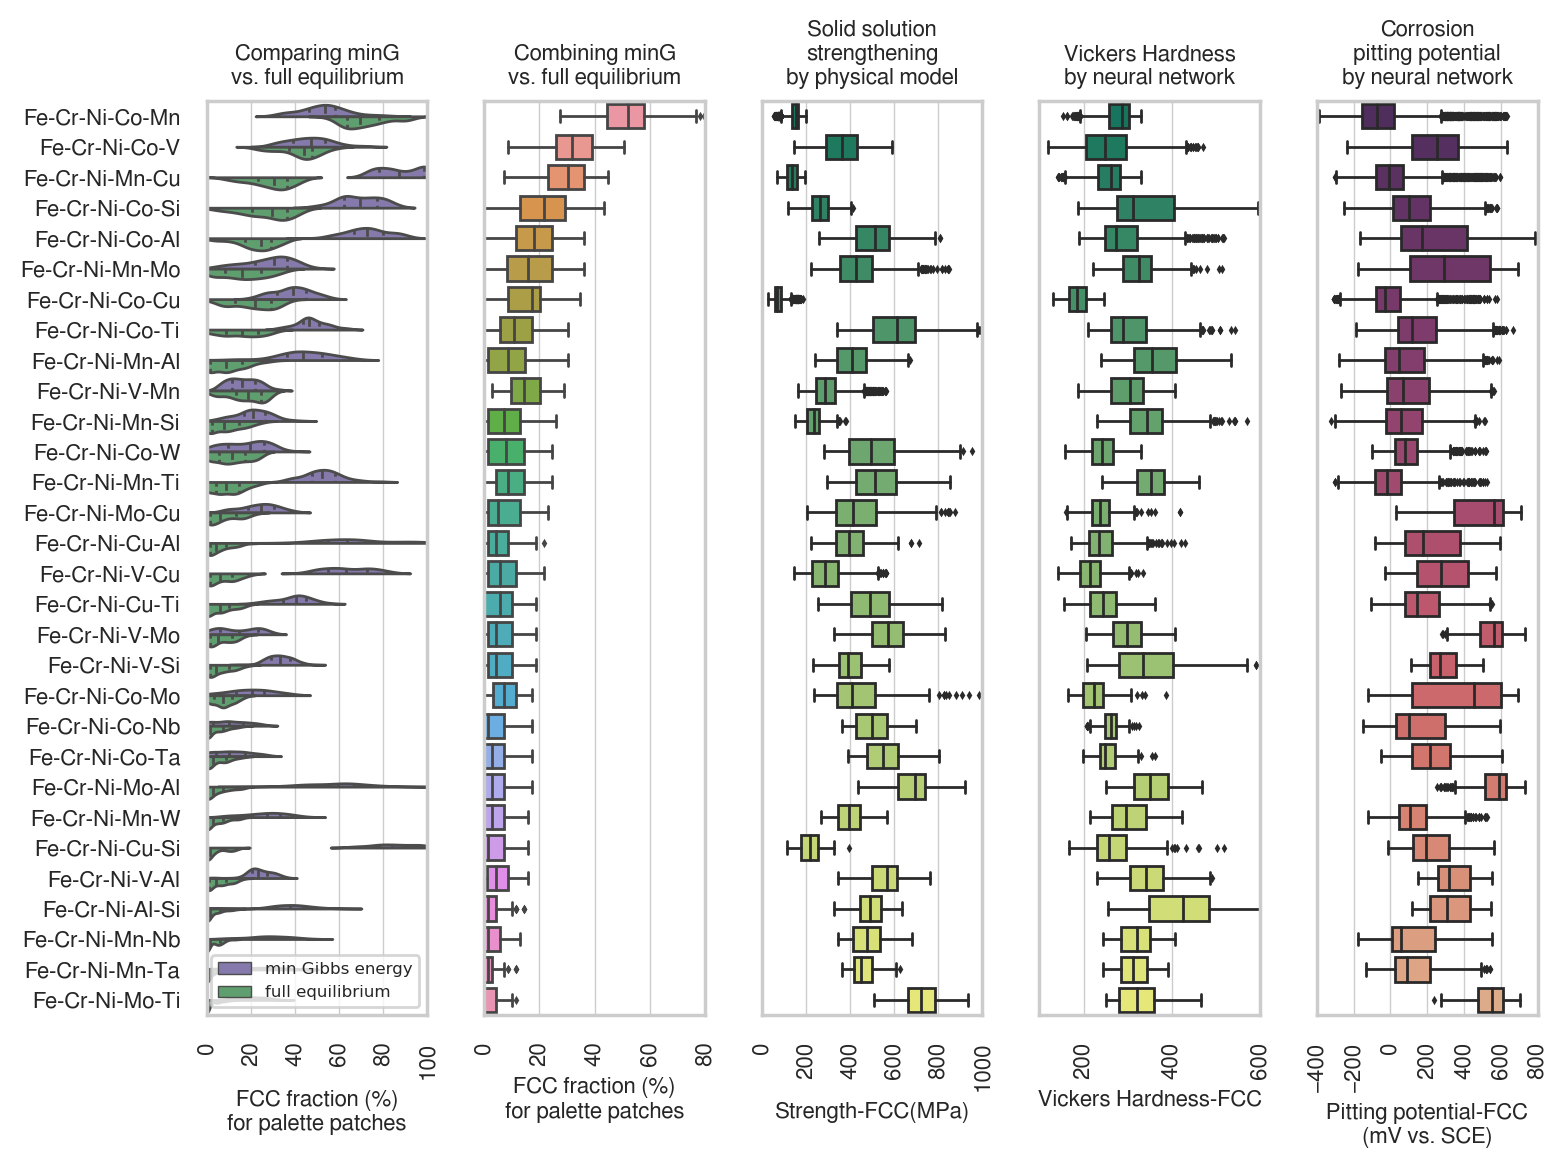

In [33]:
sns_plot(df_fcc_sns_30, df_SSS_sns_30, df_H1_C2_sns_30,
         figsize=(8, 6), rotation=90, fig_name='sns_plot_30.pdf')

### All alloys by max FCC fraction per palette


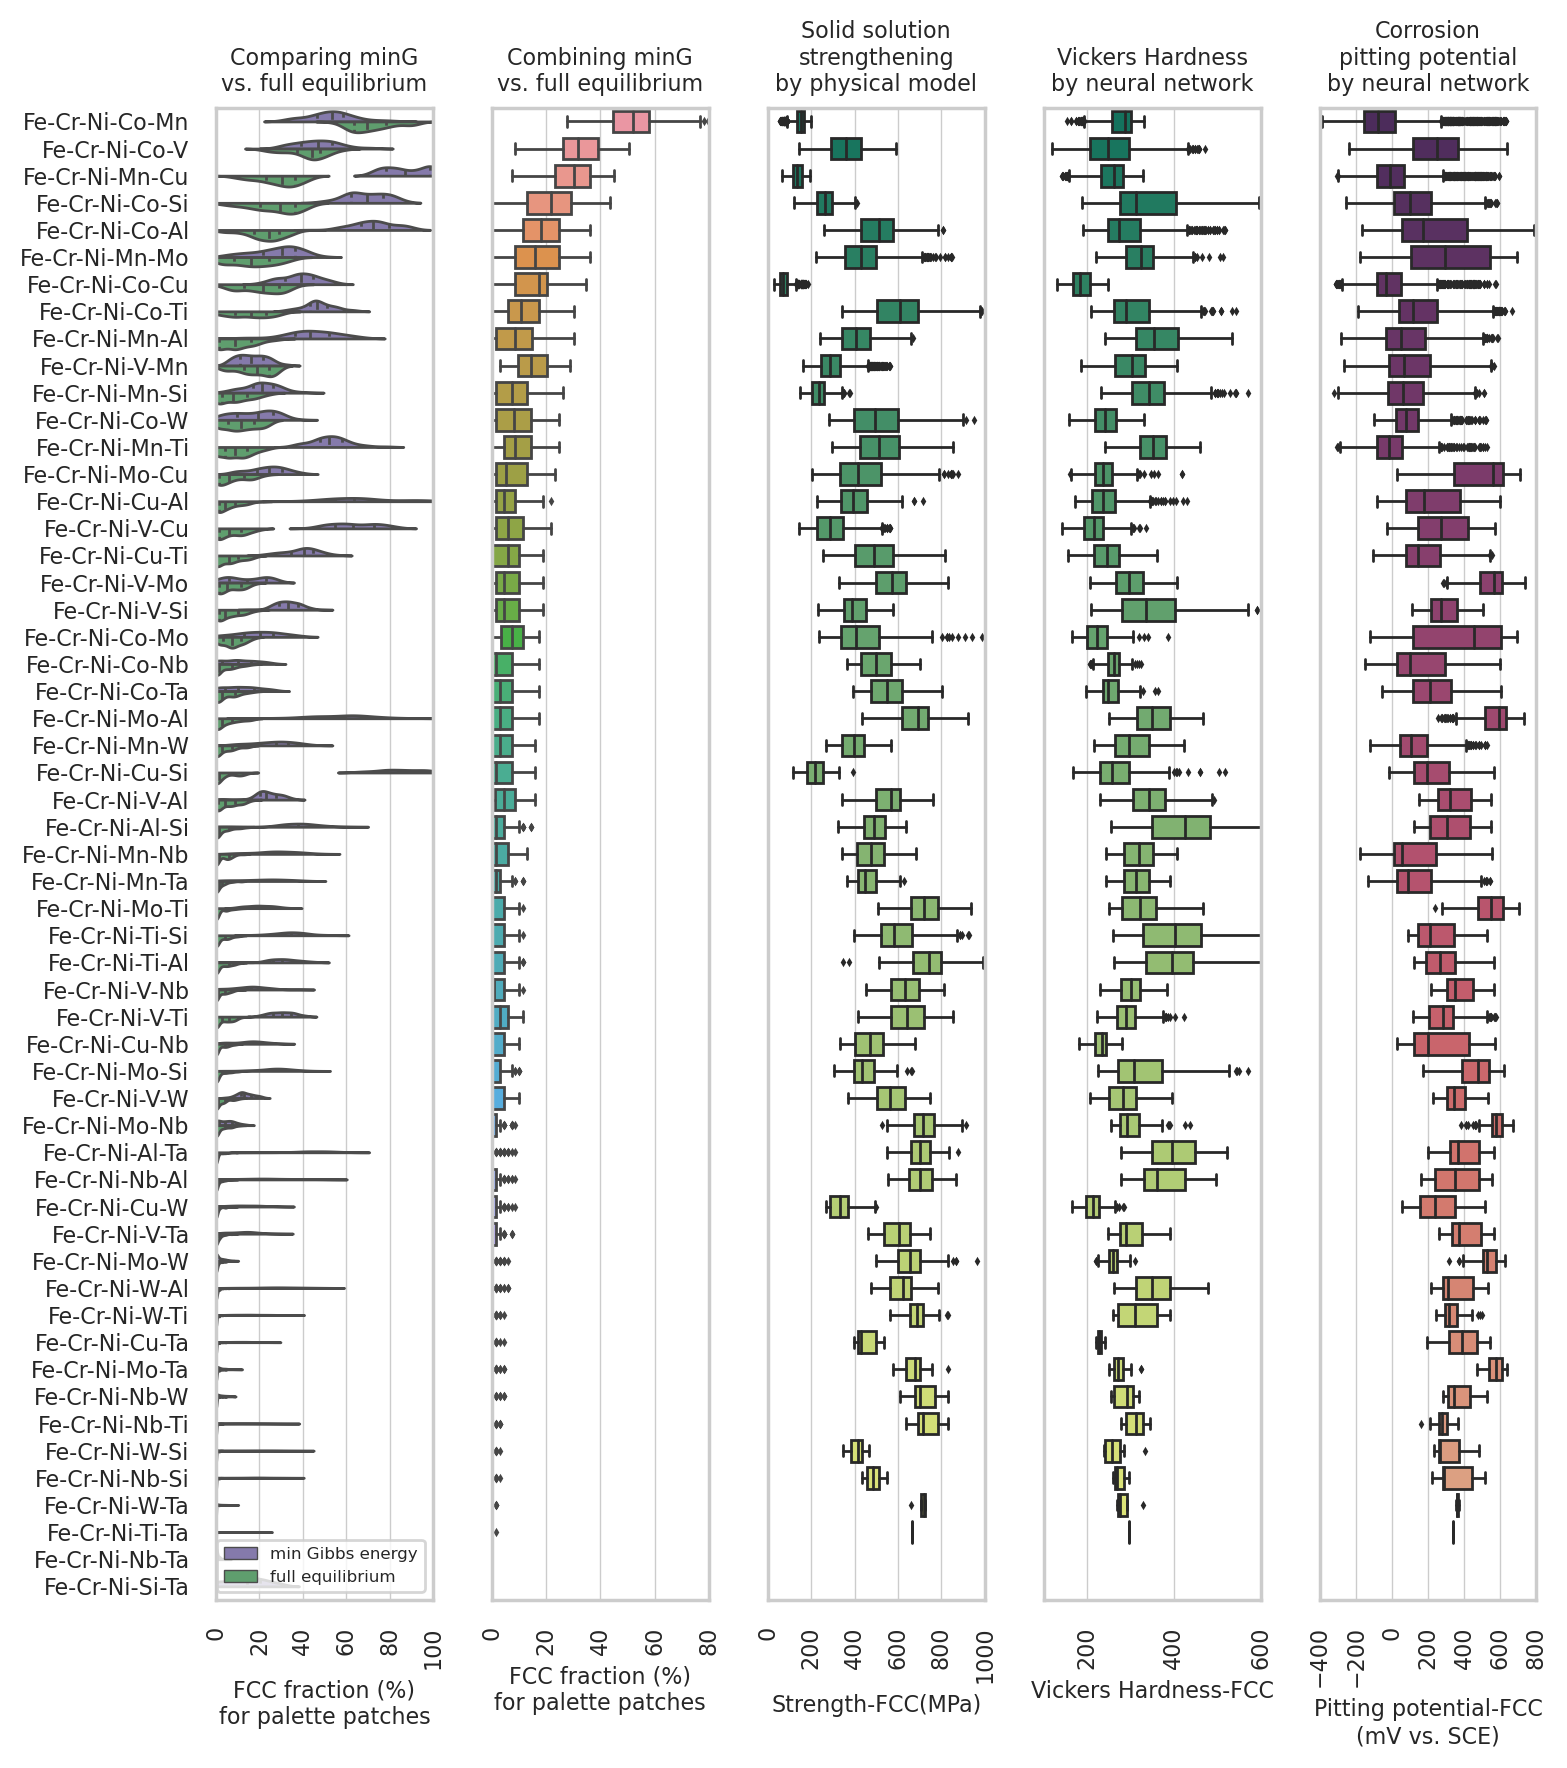

In [34]:
sns_plot(df_fcc_sns, df_SSS_sns, df_H1_C2_sns,
         figsize=(8, 9), rotation=90, fig_name='sns_plot_full.pdf')

In [35]:
# import matplotlib
# matplotlib.rcParams['font.family'] = 'FreeSans'

# fig, axs = plt.subplots(ncols=4, figsize=(6, 5), dpi=200)
# sns.set_theme(style="whitegrid")
# font_size = 7

# sns.boxplot(data=df_H1_C2_sns_30, x="H1_new_pred_KFold_mean_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[0], palette="summer")
# # sns.despine(left=True, ax=axs[2])
# axs[0].set_title('Vickers Hardness by ANN: mean', fontsize=font_size)
# axs[0].set_xlabel('Vickers Hardness', fontsize=font_size)
# axs[0].set_ylabel(None)
# axs[0].set_yticklabels([])
# axs[0].set_xlim([0, 600])
# axs[0].tick_params(axis='both', labelsize=font_size)

# sns.boxplot(data=df_H1_C2_sns_30, x="H1_new_pred_KFold_std_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[1], palette="summer")
# # sns.despine(left=True, ax=axs[2])
# axs[1].set_title('Vickers Hardness by ANN: std', fontsize=font_size)
# axs[1].set_xlabel('Vickers Hardness', fontsize=font_size)
# axs[1].set_ylabel(None)
# axs[1].set_yticklabels([])
# axs[1].set_xlim([0, 300])
# axs[1].tick_params(axis='both', labelsize=font_size)

# sns.boxplot(data=df_H1_C2_sns_30, x="C2_new_pred_KFold_mean_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[2], palette="flare_r")
# # sns.despine(left=True, ax=axs[2])
# axs[2].set_title('Corrosion pitting potential by ANN: mean',
#                  fontsize=font_size)
# axs[2].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
# axs[2].set_ylabel(None)
# axs[2].set_yticklabels([])
# axs[2].set_xlim([-300, 800])
# axs[2].tick_params(axis='both', labelsize=font_size)

# sns.boxplot(data=df_H1_C2_sns_30, x="C2_new_pred_KFold_std_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="flare_r")
# # sns.despine(left=True, ax=axs[2])
# axs[3].set_title('Corrosion pitting potential by ANN: std', fontsize=font_size)
# axs[3].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
# axs[3].set_ylabel(None)
# axs[3].set_yticklabels([])
# axs[3].set_xlim([0, 400])
# axs[3].tick_params(axis='both', labelsize=font_size)

# plt.tight_layout()
# # plt.savefig('sns_plot_30', bbox_inches='tight')
# plt.show()